In [1]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn import metrics
import re
from sklearn import preprocessing
import numpy as np
import matplotlib.pyplot as plt
import pylab as pl 
from sklearn.preprocessing import Imputer
from numpy import random
import seaborn as sb
### Set path to the data set
dataset_path = "D:\cancer_proteomes_CPTAC_itraq.csv"
clinical_info = "D:\clinical_data_breast_cancer.csv"
pam50_proteins = "D:\PAM50_proteins.csv"
 
## 数据载入，处理表头
data = pd.read_csv(dataset_path,header=0,index_col=0)
clinical = pd.read_csv(clinical_info,header=0,index_col=0)## holds clinical information about each patient/sample
pam50 = pd.read_csv(pam50_proteins,header=0)
 
## 去除symbol、name两列无，3列重复，3列健康人数据
data.drop(['gene_symbol','gene_name','AO-A12D.01TCGA','C8-A131.01TCGA','AO-A12B.01TCGA','263d3f-I.CPTAC','blcdb9-I.CPTAC','c4155b-C.CPTAC'],axis=1,inplace=True)
 
## Change the protein data sample names to a format matching the clinical data set
data.rename(columns=lambda x: "TCGA-%s" % (re.split('[_|-|.]',x)[0]) if bool(re.search("TCGA",x)) is True else x,inplace=True)
 
## 数据转置
data = data.transpose()


# 数据预处理的实现

In [16]:
#数据读取
data.head(20)

RefSeq_accession_number,NP_958782,NP_958785,NP_958786,NP_000436,NP_958781,NP_958780,NP_958783,NP_958784,NP_112598,NP_001611,...,NP_001193600,NP_061134,NP_932347,NP_003593,NP_997203,NP_001191293,NP_775791,NP_004065,NP_068752,NP_219494
TCGA-BH-A18Q,0.195341,0.215413,0.215413,0.205377,0.215413,0.215413,0.215413,0.215413,-1.035760,-0.517226,...,0.048144,NaN,-0.881872,2.527072,-8.111243,-16.029761,-2.046065,-1.778435,NaN,-3.069752
TCGA-C8-A130,-0.494060,-0.503899,-0.500619,-0.510459,-0.503899,-0.503899,-0.500619,-0.500619,-1.845366,-0.405503,...,1.457462,NaN,1.710012,0.296389,-1.753529,1.729692,-0.425182,-0.149673,NaN,-0.047997
TCGA-C8-A138,2.765081,2.779709,2.779709,2.797995,2.787023,2.779709,2.783366,2.783366,2.205538,0.749997,...,-3.250913,1.711825,-0.248402,NaN,4.707022,4.107251,-3.203370,1.971481,NaN,NaN
TCGA-E2-A154,0.862659,0.870186,0.870186,0.866423,0.870186,0.870186,0.870186,0.870186,1.920171,2.349197,...,-3.386203,-2.328692,-2.806642,NaN,-4.733495,-9.584499,-4.786183,-3.103949,NaN,NaN
TCGA-C8-A12L,1.407570,1.407570,1.410312,1.407570,1.413053,1.407570,1.410312,1.413053,3.195070,-0.007077,...,-0.503300,-2.153722,1.319840,NaN,NaN,-5.196859,NaN,-0.933726,NaN,NaN
TCGA-A2-A0EX,1.185108,1.192612,1.188860,1.185108,1.200116,1.188860,1.188860,1.192612,1.046289,2.138081,...,1.451490,-2.018981,0.877456,NaN,NaN,-6.101005,NaN,-1.726336,NaN,NaN
TCGA-AO-A12D,1.100688,1.100688,1.100688,1.100688,1.093358,1.097023,1.097023,1.097023,-2.413909,0.543630,...,NaN,NaN,0.737867,0.129501,NaN,-2.578828,NaN,1.294925,-0.189341,13.066445
TCGA-AN-A04A,0.384588,0.371393,0.371393,0.377990,0.374692,0.377990,0.374692,0.374692,-0.242170,0.051417,...,NaN,NaN,0.183366,-2.224703,NaN,0.902487,NaN,1.737065,0.361497,0.143781
TCGA-BH-A0AV,0.350536,0.367405,0.367405,0.360657,0.370779,0.367405,0.360657,0.360657,-1.650206,0.401145,...,NaN,NaN,-1.204847,-0.317503,NaN,-7.011385,NaN,-1.393788,-3.057136,NaN
TCGA-C8-A12T,-0.204918,-0.162418,-0.166668,-0.183668,-0.166668,-0.166668,-0.166668,-0.166668,2.425796,0.470823,...,-3.851368,-3.048129,-3.753620,NaN,NaN,-11.021021,NaN,NaN,NaN,NaN


In [17]:
#缺失值的填补（用中位数填充）
imputer = Imputer(missing_values='NaN', strategy='median', axis=1)
imputer = imputer.fit(data)
data = imputer.transform(data)
d=pd.DataFrame(data)
data=d
d.head(10)

,0,1,2,3,4,5,6,7,8,9,...,12543,12544,12545,12546,12547,12548,12549,12550,12551,12552
0,0.195341,0.215413,0.215413,0.205377,0.215413,0.215413,0.215413,0.215413,-1.035760,-0.517226,...,0.048144,-0.296430,-0.881872,2.527072,-8.111243,-16.029761,-2.046065,-1.778435,-0.296430,-3.069752
1,-0.494060,-0.503899,-0.500619,-0.510459,-0.503899,-0.503899,-0.500619,-0.500619,-1.845366,-0.405503,...,1.457462,0.024160,1.710012,0.296389,-1.753529,1.729692,-0.425182,-0.149673,0.024160,-0.047997
2,2.765081,2.779709,2.779709,2.797995,2.787023,2.779709,2.783366,2.783366,2.205538,0.749997,...,-3.250913,1.711825,-0.248402,0.088055,4.707022,4.107251,-3.203370,1.971481,0.088055,0.088055
3,0.862659,0.870186,0.870186,0.866423,0.870186,0.870186,0.870186,0.870186,1.920171,2.349197,...,-3.386203,-2.328692,-2.806642,-0.157218,-4.733495,-9.584499,-4.786183,-3.103949,-0.157218,-0.157218
4,1.407570,1.407570,1.410312,1.407570,1.413053,1.407570,1.410312,1.413053,3.195070,-0.007077,...,-0.503300,-2.153722,1.319840,-0.231885,-0.231885,-5.196859,-0.231885,-0.933726,-0.231885,-0.231885
5,1.185108,1.192612,1.188860,1.185108,1.200116,1.188860,1.188860,1.192612,1.046289,2.138081,...,1.451490,-2.018981,0.877456,0.037039,0.037039,-6.101005,0.037039,-1.726336,0.037039,0.037039
6,1.100688,1.100688,1.100688,1.100688,1.093358,1.097023,1.097023,1.097023,-2.413909,0.543630,...,0.045209,0.045209,0.737867,0.129501,0.045209,-2.578828,0.045209,1.294925,-0.189341,13.066445
7,0.384588,0.371393,0.371393,0.377990,0.374692,0.377990,0.374692,0.374692,-0.242170,0.051417,...,-0.047545,-0.047545,0.183366,-2.224703,-0.047545,0.902487,-0.047545,1.737065,0.361497,0.143781
8,0.350536,0.367405,0.367405,0.360657,0.370779,0.367405,0.360657,0.360657,-1.650206,0.401145,...,-0.189294,-0.189294,-1.204847,-0.317503,-0.189294,-7.011385,-0.189294,-1.393788,-3.057136,-0.189294
9,-0.204918,-0.162418,-0.166668,-0.183668,-0.166668,-0.166668,-0.166668,-0.166668,2.425796,0.470823,...,-3.851368,-3.048129,-3.753620,-0.485414,-0.485414,-11.021021,-0.485414,-0.485414,-0.485414,-0.485414


In [18]:

#数据Z-scale 标准化
from sklearn import preprocessing
data_scaled = preprocessing.scale(d)
s=pd.DataFrame(data_scaled)
s.head(20)

,0,1,2,3,4,5,6,7,8,9,...,12543,12544,12545,12546,12547,12548,12549,12550,12551,12552
0,-0.101691,-0.086794,-0.086432,-0.093717,-0.086628,-0.086365,-0.085716,-0.085796,-0.343337,-0.616115,...,0.321067,0.166276,-0.778431,1.380319,-1.593054,-2.966501,-1.302988,-1.446642,0.001937,-0.880355
1,-0.819765,-0.834119,-0.830527,-0.838558,-0.833258,-0.834001,-0.829150,-0.829164,-0.742592,-0.540192,...,0.825458,0.446622,1.443705,0.064036,0.011577,0.841567,-0.108223,0.075396,0.225224,0.207314
2,2.574933,2.577366,2.578363,2.603955,2.582646,2.578906,2.580509,2.580190,1.255098,0.245056,...,-0.859655,1.922431,-0.235330,-0.058898,1.642164,1.351374,-2.156047,2.057565,0.269726,0.256285
3,0.593384,0.593478,0.594003,0.594115,0.593012,0.594191,0.594114,0.593973,1.114370,1.331830,...,-0.908075,-1.610871,-2.428621,-0.203629,-0.740540,-1.584477,-3.322750,-2.685304,0.098896,0.168000
4,1.160959,1.151791,1.155297,1.157190,1.156496,1.152736,1.154910,1.157565,1.743083,-0.269432,...,0.123707,-1.457866,1.109194,-0.247689,0.395627,-0.643658,0.034258,-0.657282,0.046892,0.141124
5,0.929244,0.928461,0.925166,0.925714,0.935471,0.925414,0.924983,0.928708,0.683418,1.188362,...,0.823321,-1.340039,0.729918,-0.089002,0.463501,-0.837529,0.232484,-1.397957,0.234194,0.237922
6,0.841313,0.832957,0.833538,0.837873,0.824659,0.829961,0.829632,0.829470,-1.022967,0.104814,...,0.320017,0.465029,0.610243,-0.034441,0.465563,-0.082287,0.238506,1.425339,0.076523,4.927806
7,0.095428,0.075260,0.075661,0.085891,0.078699,0.082614,0.079658,0.079563,0.048019,-0.229681,...,0.286821,0.383919,0.134844,-1.423612,0.442153,0.664193,0.170136,1.838508,0.460174,0.276344
8,0.059959,0.071117,0.071517,0.067856,0.074638,0.071613,0.065086,0.064993,-0.646350,0.007985,...,0.236089,0.259964,-1.055332,-0.298210,0.406377,-1.032737,0.065652,-1.087199,-1.920857,0.156455
9,-0.518597,-0.479340,-0.483488,-0.498526,-0.483220,-0.483491,-0.482420,-0.482464,1.363718,0.055337,...,-1.074556,-2.239996,-3.240507,-0.397291,0.331638,-1.892503,-0.152620,-0.238346,-0.129688,0.049867


In [19]:
#数据正则化
normalizer=preprocessing.normalize(s,norm='l2')
s=pd.DataFrame(normalizer)
s.head(10)

,0,1,2,3,4,5,6,7,8,9,...,12543,12544,12545,12546,12547,12548,12549,12550,12551,12552
0,-0.000812,-0.000693,-0.000690,-0.000748,-0.000691,-0.000689,-0.000684,-0.000685,-0.002740,-0.004917,...,0.002562,0.001327,-0.006213,0.011016,-0.012714,-0.023675,-0.010399,-0.011546,0.000015,-0.007026
1,-0.008241,-0.008386,-0.008350,-0.008430,-0.008377,-0.008384,-0.008336,-0.008336,-0.007465,-0.005431,...,0.008299,0.004490,0.014514,0.000644,0.000116,0.008461,-0.001088,0.000758,0.002264,0.002084
2,0.022112,0.022133,0.022142,0.022361,0.022178,0.022146,0.022160,0.022157,0.010778,0.002104,...,-0.007382,0.016509,-0.002021,-0.000506,0.014102,0.011605,-0.018515,0.017669,0.002316,0.002201
3,0.004730,0.004730,0.004735,0.004736,0.004727,0.004736,0.004736,0.004734,0.008882,0.010616,...,-0.007238,-0.012840,-0.019358,-0.001623,-0.005903,-0.012630,-0.026485,-0.021404,0.000788,0.001339
4,0.011275,0.011186,0.011220,0.011238,0.011231,0.011195,0.011216,0.011242,0.016928,-0.002617,...,0.001201,-0.014158,0.010772,-0.002405,0.003842,-0.006251,0.000333,-0.006383,0.000455,0.001371
5,0.009165,0.009157,0.009125,0.009130,0.009226,0.009127,0.009123,0.009160,0.006740,0.011721,...,0.008120,-0.013217,0.007199,-0.000878,0.004571,-0.008260,0.002293,-0.013788,0.002310,0.002347
6,0.007150,0.007079,0.007084,0.007121,0.007009,0.007054,0.007051,0.007050,-0.008694,0.000891,...,0.002720,0.003952,0.005186,-0.000293,0.003957,-0.000699,0.002027,0.012114,0.000650,0.041881
7,0.000866,0.000683,0.000686,0.000779,0.000714,0.000750,0.000723,0.000722,0.000436,-0.002084,...,0.002602,0.003483,0.001223,-0.012916,0.004012,0.006026,0.001544,0.016680,0.004175,0.002507
8,0.000549,0.000652,0.000655,0.000622,0.000684,0.000656,0.000596,0.000595,-0.005922,0.000073,...,0.002163,0.002382,-0.009669,-0.002732,0.003723,-0.009462,0.000602,-0.009961,-0.017600,0.001434
9,-0.003930,-0.003632,-0.003664,-0.003778,-0.003662,-0.003664,-0.003656,-0.003656,0.010334,0.000419,...,-0.008143,-0.016975,-0.024556,-0.003011,0.002513,-0.014341,-0.001157,-0.001806,-0.000983,0.000378


In [20]:
#异常值删除，对Z-scale中大于和小于3的值
p = preprocessing.scale(s)
n1=[]
for i in p:
    if  (i>3).all()&(i<-3).all(): continue
    n1.append(i)
n1=pd.DataFrame(n1)

#对删除的异常值填补（用中位数填充）
imputer = Imputer(missing_values='NaN', strategy='mean', axis=1)
imputer = imputer.fit(n1)
data = imputer.transform(n1)
d=pd.DataFrame(n1)
d.head(10)

,0,1,2,3,4,5,6,7,8,9,...,12543,12544,12545,12546,12547,12548,12549,12550,12551,12552
0,-0.100876,-0.087080,-0.086764,-0.093288,-0.087027,-0.086847,-0.086287,-0.086361,-0.283988,-0.528103,...,0.243751,0.119230,-0.765646,1.200332,-1.429561,-2.731874,-1.223326,-1.484360,-0.037440,-0.863678
1,-0.917057,-0.931697,-0.927725,-0.936935,-0.930814,-0.931783,-0.926554,-0.926563,-0.797967,-0.584047,...,0.877415,0.482194,1.633124,0.059702,-0.000072,0.936652,-0.160514,0.055596,0.214792,0.218533
2,2.417365,2.418979,2.419895,2.444497,2.423793,2.420506,2.422360,2.422024,1.186401,0.236806,...,-0.854819,1.861393,-0.280522,-0.066711,1.558123,1.295601,-2.149721,2.172278,0.220626,0.232390
3,0.507856,0.508338,0.508790,0.508893,0.507820,0.508870,0.508878,0.508743,0.980206,1.164007,...,-0.838893,-1.506482,-2.287020,-0.189578,-0.670683,-1.470918,-3.059460,-2.718288,0.049243,0.130023
4,1.226838,1.217054,1.220779,1.222975,1.221941,1.218033,1.220525,1.223336,1.855327,-0.277485,...,0.093400,-1.657746,1.200043,-0.275610,0.415029,-0.742753,0.001651,-0.838223,0.011904,0.133757
5,0.995087,0.994363,0.990783,0.991498,1.001830,0.991013,0.990690,0.994706,0.747226,1.284375,...,0.857724,-1.549714,0.786543,-0.107622,0.496285,-0.972158,0.225407,-1.765024,0.219905,0.249705
6,0.773747,0.766199,0.766732,0.770845,0.758340,0.763334,0.763138,0.762971,-0.931594,0.104599,...,0.261133,0.420477,0.553598,-0.043280,0.427796,-0.109006,0.195051,1.476923,0.033772,4.945971
7,0.083390,0.063939,0.064335,0.074425,0.067268,0.071135,0.068203,0.068102,0.061447,-0.219449,...,0.248152,0.366658,0.094952,-1.431439,0.433903,0.658744,0.139871,2.048502,0.429115,0.268783
8,0.048630,0.060513,0.060912,0.057125,0.063959,0.060881,0.054327,0.054226,-0.630097,0.015528,...,0.199646,0.240281,-1.165720,-0.311559,0.401801,-1.109370,0.032339,-1.286087,-2.013233,0.141238
9,-0.443432,-0.409834,-0.413283,-0.426016,-0.413145,-0.413459,-0.412621,-0.412658,1.138113,0.053240,...,-0.938848,-1.980944,-2.888639,-0.342164,0.266959,-1.666321,-0.168338,-0.265342,-0.149404,0.015841


# 对PAM50 mRNA进行聚类分析

In [3]:
## 数据载入，处理表头
data = pd.read_csv(dataset_path,header=0,index_col=0)
clinical = pd.read_csv(clinical_info,header=0,index_col=0)## holds clinical information about each patient/sample
pam50 = pd.read_csv(pam50_proteins,header=0)
 
## 去除symbol、name两列无，3列重复，3列健康人数据
data.drop(['gene_symbol','gene_name','AO-A12D.01TCGA','C8-A131.01TCGA','AO-A12B.01TCGA','263d3f-I.CPTAC','blcdb9-I.CPTAC','c4155b-C.CPTAC'],axis=1,inplace=True)
 
## Change the protein data sample names to a format matching the clinical data set
data.rename(columns=lambda x: "TCGA-%s" % (re.split('[_|-|.]',x)[0]) if bool(re.search("TCGA",x)) is True else x,inplace=True)
 
## 数据转置
data = data.transpose()
## 对第二个文件进行表头处理
clinical = clinical.loc[[x for x in clinical.index.tolist() if x in data.index],:]

## 将clinical中数据与77_cancer_proteomes中数据进行整合，放在一起
merged = data.merge(clinical,left_index=True,right_index=True)
 
## 更改名称方便识别
processed = merged
 
## 将第二问中用不到的clinical中部分数据进行删除
processed_numerical = processed.loc[:,[x for x in processed.columns if bool(re.search("NP_|XP_",x)) == True]]

#将第三个文件中出现的PAM50蛋白质与第一个文件对应进行筛选，得到有用的43个基因
processed_numerical_p50 = processed_numerical.ix[:,processed_numerical.columns.isin(pam50['RefSeqProteinID'])]
processed1=pd.DataFrame(processed_numerical_p50)
processed1.head(10)

RefSeq_accession_number,NP_057427,NP_002408,NP_000415,NP_000413,NP_000517,NP_004439,NP_005219,NP_058519,NP_058518,NP_001116539,...,NP_057547,NP_054895,NP_001246,NP_055606,NP_036451,NP_000624,NP_569082,NP_001159,NP_001229,NP_002458
TCGA-A2-A0CM,2.160157,2.623021,4.768355,0.639321,4.933663,-4.419112,-0.271711,-6.013418,-6.013418,-6.318320,...,-1.292949,3.541400,3.177722,NaN,-1.792547,NaN,NaN,2.516489,2.556897,NaN
TCGA-BH-A18Q,-0.179342,-1.463969,2.182497,2.319658,2.399947,-5.187379,-1.922286,-7.703106,-8.218295,-8.188186,...,-2.624816,-0.717949,0.539915,0.001309,-0.641005,-0.627623,NaN,-0.888563,-3.581595,NaN
TCGA-A7-A0CE,1.761673,-0.583448,5.542903,6.038440,2.080457,-3.099008,-1.009547,-3.717640,-3.556670,-3.556670,...,-3.329417,1.922643,2.935811,NaN,-2.253124,-3.430418,NaN,0.997851,1.209322,NaN
TCGA-D8-A142,-0.415696,-1.232627,-2.823113,1.724231,0.668726,-3.130366,-0.462687,-6.427009,-6.195666,-6.427009,...,-2.320664,-1.232627,-1.438667,NaN,NaN,-0.910915,NaN,-0.075910,-0.101213,-7.659635
TCGA-AO-A0J6,-0.075090,-1.159168,0.650452,0.498004,0.661745,-2.062567,-0.394103,-1.015189,-0.893795,-0.913557,...,-0.577605,-2.003281,-4.278717,-0.125906,-3.451542,-0.176722,1.567966,-0.859917,NaN,NaN
TCGA-A2-A0YM,0.000077,-1.320640,0.291277,-0.534171,-0.781806,-3.322351,-0.373667,-3.060959,-3.060959,-2.939435,...,NaN,-2.194239,1.621165,NaN,NaN,-1.001925,NaN,-0.414940,NaN,NaN
TCGA-A2-A0D2,2.249702,3.576941,2.169868,2.968207,0.543251,-5.421010,-1.206443,-5.297932,-5.277974,-5.311238,...,-3.694601,2.495856,2.722053,0.373604,-1.342826,-4.183584,-2.889608,3.487128,NaN,-0.714133
TCGA-A2-A0SX,1.457488,1.385987,5.625404,3.271828,2.166540,-4.891209,-1.774955,-4.414536,-4.414536,-3.776985,...,NaN,-2.063939,0.313471,NaN,NaN,-1.337011,NaN,0.393910,NaN,NaN
TCGA-AO-A0JL,1.359573,-1.177327,-6.194613,-3.648293,-2.263673,-1.770736,-1.959120,-2.690676,-2.618462,-2.831964,...,-1.868067,3.585640,-0.882193,NaN,1.617031,-0.618456,NaN,0.618597,NaN,NaN
TCGA-AO-A12F,2.386411,0.192221,0.192221,2.260818,1.066449,-2.036447,-1.260723,-2.918063,-2.959928,-2.964853,...,-1.615339,1.494944,1.470318,2.329771,-0.425896,-2.339348,NaN,1.554047,NaN,0.569001


In [6]:
#对第二问中要用到的数据进行预处理

#缺失值的填补（用中位数填充）
imputer = Imputer(missing_values='NaN', strategy='mean', axis=1)
imputer = imputer.fit(processed_numerical_p50)
data_imputer = imputer.transform(processed_numerical_p50)

#数据Z-scale 标准化
from sklearn import preprocessing
data_scaled = preprocessing.scale(data_imputer)

#数据正则化处理
normalizer=preprocessing.normalize(data_scaled,norm='l2')
data_norm=pd.DataFrame(normalizer)
data_norm.head(10)

,0,1,2,3,4,5,6,7,8,9,...,33,34,35,36,37,38,39,40,41,42
0,0.217855,0.204112,0.268311,0.110370,0.305653,-0.098490,0.081447,-0.115025,-0.114708,-0.119633,...,-0.042434,0.261984,0.218197,0.016138,-0.076562,0.025027,0.066266,0.213964,0.179175,0.052725
1,0.008876,-0.066306,0.222457,0.226175,0.243825,-0.165965,-0.007347,-0.214988,-0.235015,-0.226067,...,-0.158500,-0.038180,0.089444,0.044076,-0.015288,-0.005313,-0.087832,-0.053353,-0.284456,-0.008669
2,0.193682,0.004187,0.316631,0.335518,0.183986,-0.051335,0.045261,-0.049472,-0.043605,-0.041863,...,-0.174716,0.161035,0.217733,0.031418,-0.109108,-0.216049,0.090482,0.106706,0.097712,0.064978
3,-0.017202,-0.043455,-0.019814,0.179912,0.127142,-0.058670,0.084746,-0.151250,-0.142704,-0.145808,...,-0.123294,-0.076704,-0.051268,-0.117962,-0.080418,-0.028719,-0.113265,0.023509,0.008045,-0.384292
4,0.026870,-0.052975,0.188200,0.173790,0.176666,-0.014469,0.124104,0.056664,0.064521,0.062141,...,0.000500,-0.194154,-0.337574,0.039006,-0.281197,0.046169,0.446393,-0.064415,-0.031552,0.063620
5,0.044612,-0.081584,0.194284,0.127669,0.076631,-0.109943,0.147441,-0.052053,-0.050539,-0.041419,...,-0.013603,-0.252714,0.252112,-0.044940,-0.029259,-0.059395,0.021748,-0.010843,-0.062162,0.054857
6,0.179723,0.209739,0.135835,0.158054,0.080527,-0.108699,0.025551,-0.074503,-0.073684,-0.071867,...,-0.147891,0.151507,0.153048,0.051101,-0.040774,-0.203918,-0.189581,0.228033,0.003666,0.021950
7,0.193625,0.159042,0.376642,0.263481,0.221625,-0.145988,0.002657,-0.084328,-0.083615,-0.057315,...,-0.021436,-0.152249,0.070228,-0.046287,-0.030825,-0.068204,-0.010049,0.068923,-0.053920,0.024776
8,0.217930,-0.049594,-0.214363,-0.078160,-0.044086,0.003548,-0.011370,-0.023638,-0.019137,-0.027298,...,-0.114909,0.396544,-0.017461,-0.045898,0.172507,-0.005146,0.001104,0.107460,-0.056913,0.035389
9,0.340649,0.074856,0.137989,0.245717,0.179561,-0.011078,0.041828,-0.032294,-0.032941,-0.031608,...,-0.088206,0.174412,0.173749,0.319560,0.000480,-0.179457,0.061307,0.202847,-0.020093,0.132221


In [7]:

# ## 利用KMeans进行聚类计算
n_clusters = [2,3,4,5,6,7,8,10,20,76]
def compare_k_means(k_list,data_norm):
## 将处理过的数据分成不同类别
    for k in k_list:
        clusterer = KMeans(n_clusters=k, n_jobs=4)
        clusterer.fit(data_norm)
        ## The higher (up to 1) the better
        print("Silhouette Coefficient for k == %s: %s" % (
        k, round(metrics.silhouette_score(data_norm, clusterer.labels_), 4)))
        ## The higher (up to 1) the better
        print("Homogeneity score for k == %s: %s" % (
        k, round(metrics.homogeneity_score(processed['PAM50 mRNA'], clusterer.labels_),4)))
        print("------------------------")

## 从大的蛋白质库里随机取43个蛋白质
processed_numerical_random = processed_numerical.iloc[:,random.choice(range(processed_numerical.shape[1]),43)]
imputer_rnd = imputer.fit(processed_numerical_random)
processed_numerical_random = imputer_rnd.transform(processed_numerical_random)



## 利用筛选出的43蛋白质进行聚类分析
compare_k_means(n_clusters,data_norm)


## 将随机选取的43个蛋白质与筛选出的43个进行结果对照
compare_k_means(n_clusters,processed_numerical_random)
## The scores should be significantly lower than for the PAM50 proteins!


Silhouette Coefficient for k == 2: 0.1524
Homogeneity score for k == 2: 0.1597
------------------------
Silhouette Coefficient for k == 3: 0.146
Homogeneity score for k == 3: 0.4119
------------------------
Silhouette Coefficient for k == 4: 0.1497
Homogeneity score for k == 4: 0.4875
------------------------
Silhouette Coefficient for k == 5: 0.1308
Homogeneity score for k == 5: 0.5125
------------------------
Silhouette Coefficient for k == 6: 0.1066
Homogeneity score for k == 6: 0.4945
------------------------
Silhouette Coefficient for k == 7: 0.1004
Homogeneity score for k == 7: 0.5224
------------------------
Silhouette Coefficient for k == 8: 0.101
Homogeneity score for k == 8: 0.5719
------------------------
Silhouette Coefficient for k == 10: 0.07
Homogeneity score for k == 10: 0.5464
------------------------
Silhouette Coefficient for k == 20: 0.1087
Homogeneity score for k == 20: 0.6608
------------------------
Silhouette Coefficient for k == 76: 0.9754
Homogeneity score for

C:\Users\zhu hanfeng\Anaconda3\lib\site-packages\ipykernel\__main__.py:5: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


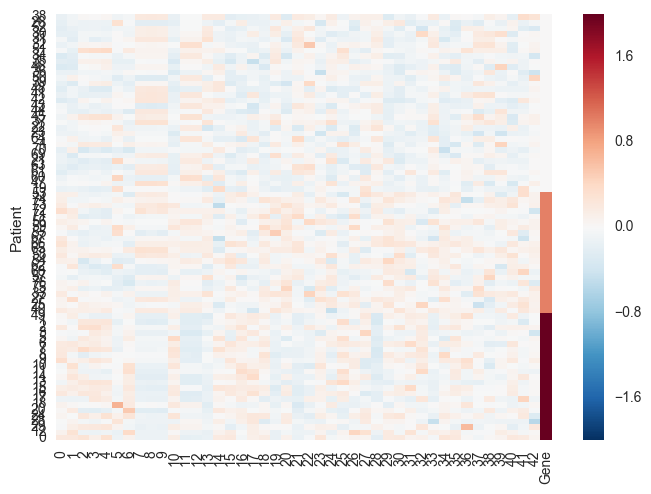

In [8]:
clusterer_final = KMeans(n_clusters=3, n_jobs=4)
clusterer_final = clusterer_final.fit(data_norm)
processed_p50_plot = pd.DataFrame(data_norm)
processed_p50_plot['Gene'] = clusterer_final.labels_
processed_p50_plot.sort('Gene',axis=0,inplace=True)
 
## Look at the heatmap of protein expression in all patients and look at their assigned cluster
## Proteins can either be more expressed (more is produced, less degraded), not changed or lower expressed than the used reference
## Since each protein has a distinct function in the cell, their levels describe the functional/signaling state the cell is in.
#画出热力图
processed_p50_plot.index.name = 'Patient'
s=sb.heatmap(processed_p50_plot)
pl.show()

# 问题三：对77个病人进行分类

In [125]:
#训练集、测试集的划分，利用77个病人的43个蛋白质作为分类标准，
from sklearn import cross_validation
Y=processed['PAM50 mRNA']
#以随机选取的70%作为训练集，剩下的30%作为测试集,不对数据进行处理
train_x, test_x, train_y, test_y = cross_validation.train_test_split(data_imputer, Y, test_size=0.3, random_state=0) 


In [126]:
#首先利用朴素贝叶斯进行分类
from sklearn.naive_bayes  import GaussianNB
model1 = GaussianNB()
model1.fit(train_x,train_y)
pred = model1.predict(test_x)
from sklearn import metrics
print(metrics.classification_report(test_y,pred))

print(metrics.accuracy_score(test_y,pred))


             precision    recall  f1-score   support

 Basal-like       1.00      0.50      0.67         2
HER2-enriched       0.20      0.33      0.25         3
  Luminal A       0.73      0.89      0.80         9
  Luminal B       0.71      0.50      0.59        10

avg / total       0.68      0.62      0.63        24

0.625


In [73]:
#利用随机森林进行分类
from sklearn.ensemble  import RandomForestClassifier
model2 = RandomForestClassifier(n_estimators=50)
model2.fit(train_x,train_y)
pred = model2.predict(test_x)
from sklearn import metrics
print(metrics.classification_report(test_y,pred))

print(metrics.accuracy_score(test_y,pred))

             precision    recall  f1-score   support

 Basal-like       0.67      1.00      0.80         2
HER2-enriched       0.50      0.67      0.57         3
  Luminal A       0.78      0.78      0.78         9
  Luminal B       0.88      0.70      0.78        10

avg / total       0.77      0.75      0.75        24

0.75


In [198]:
#利用K近邻进行分类
from sklearn.neighbors  import KNeighborsClassifier
model3 = KNeighborsClassifier(n_neighbors=12)
model3.fit(train_x,train_y)
pred = model3.predict(test_x)
from sklearn import metrics
print(metrics.classification_report(test_y,pred))

print(metrics.accuracy_score(test_y,pred))

             precision    recall  f1-score   support

 Basal-like       0.50      1.00      0.67         2
HER2-enriched       0.67      0.67      0.67         3
  Luminal A       0.78      0.78      0.78         9
  Luminal B       0.88      0.70      0.78        10

avg / total       0.78      0.75      0.75        24

0.75


In [548]:
#训练集、测试集的划分，利用77个病人的43个蛋白质作为分类标准，
from sklearn import cross_validation
Y=processed['PAM50 mRNA']
#以随机选取的70%作为训练集，剩下的30%作为测试集,利用处理过的数据（异常值删除，正则化，标准化）
train_x, test_x, train_y, test_y = cross_validation.train_test_split(data_norm, Y, test_size=0.3, random_state=0) 

In [301]:
#利用处理过的数据再次进行朴素贝叶斯，发现效果有所提高
from sklearn.naive_bayes  import GaussianNB
model1 = GaussianNB()
model1.fit(train_x,train_y)
pred = model1.predict(test_x)
from sklearn import metrics
print(metrics.classification_report(test_y,pred))

print(metrics.accuracy_score(test_y,pred))

             precision    recall  f1-score   support

 Basal-like       1.00      0.50      0.67         2
HER2-enriched       0.20      0.33      0.25         3
  Luminal A       0.80      0.89      0.84         9
  Luminal B       0.75      0.60      0.67        10

avg / total       0.72      0.67      0.68        24

0.666666666667


In [109]:
#利用处理过的数据再次进行随机森林，效果也有所提高
from sklearn.ensemble  import RandomForestClassifier
model2 = RandomForestClassifier(n_estimators=50)
model2.fit(train_x,train_y)
pred = model2.predict(test_x)
from sklearn import metrics
print(metrics.classification_report(test_y,pred))

print(metrics.accuracy_score(test_y,pred))

             precision    recall  f1-score   support

 Basal-like       1.00      1.00      1.00         2
HER2-enriched       0.50      0.67      0.57         3
  Luminal A       0.80      0.89      0.84         9
  Luminal B       0.88      0.70      0.78        10

avg / total       0.81      0.79      0.79        24

0.791666666667


In [553]:
#利用处理过数据进行K近邻，发现效果没有提高
from sklearn.neighbors  import KNeighborsClassifier
model3 = KNeighborsClassifier(n_neighbors=12)
model3.fit(train_x,train_y)
pred = model3.predict(test_x)
from sklearn import metrics
print(metrics.classification_report(test_y,pred))

print(metrics.accuracy_score(test_y,pred))

             precision    recall  f1-score   support

 Basal-like       0.67      1.00      0.80         2
HER2-enriched       0.50      0.67      0.57         3
  Luminal A       0.80      0.89      0.84         9
  Luminal B       0.86      0.60      0.71        10

avg / total       0.78      0.75      0.75        24

0.75


Feature ranking:
1. feature 21 (0.078069)
2. feature 25 (0.076630)
3. feature 28 (0.056536)
4. feature 5 (0.047741)
5. feature 7 (0.041535)
6. feature 15 (0.037517)
7. feature 12 (0.037188)
8. feature 20 (0.031022)
9. feature 11 (0.030953)
10. feature 19 (0.029999)
11. feature 0 (0.027369)
12. feature 8 (0.026951)
13. feature 9 (0.025823)
14. feature 6 (0.025797)
15. feature 3 (0.023397)
16. feature 29 (0.022022)
17. feature 40 (0.021189)
18. feature 10 (0.020664)
19. feature 37 (0.019712)
20. feature 1 (0.019015)
21. feature 38 (0.018710)
22. feature 39 (0.017961)
23. feature 36 (0.017920)
24. feature 2 (0.017878)
25. feature 32 (0.016608)
26. feature 17 (0.016392)
27. feature 4 (0.015401)
28. feature 33 (0.014381)
29. feature 13 (0.014071)
30. feature 14 (0.013907)
31. feature 41 (0.013729)
32. feature 30 (0.013250)
33. feature 16 (0.013023)
34. feature 35 (0.012134)
35. feature 34 (0.012131)
36. feature 18 (0.010988)
37. feature 23 (0.010643)
38. feature 27 (0.010482)
39. feature 26

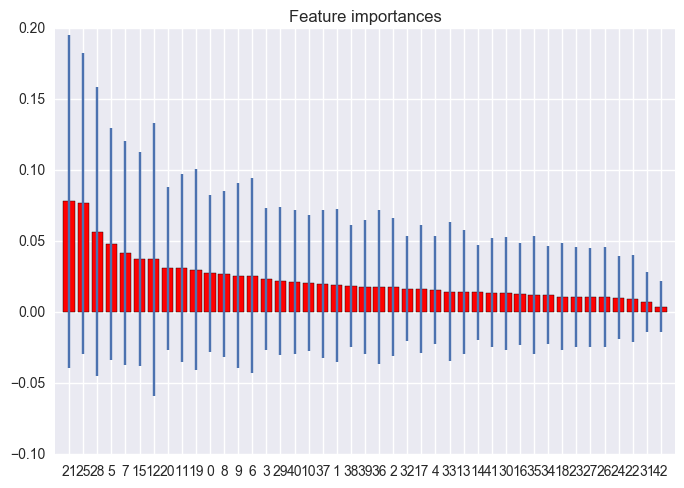

In [75]:
## 各个蛋白质基因的重要性,利用随机森林的结果
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier

importances = model2.feature_importances_
std = np.std([tree.feature_importances_ for tree in model2.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# 对各个基因重要性进行排序
print("Feature ranking:")

for f in range(train_x.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# 绘制图形
plt.figure()
plt.title("Feature importances")
plt.bar(range(train_x.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(train_x.shape[1]), indices)
plt.xlim([-1, train_x.shape[1]])
plt.show()


# 第四问:如何判断Clinicaly（第二个文件）中已知的其他分类结果是否也用了PAM50 mRNA所用到的43个蛋白质基因？


In [140]:
## 数据载入，处理表头
data = pd.read_csv(dataset_path,header=0,index_col=0)
clinical = pd.read_csv(clinical_info,header=0,index_col=0)## holds clinical information about each patient/sample
pam50 = pd.read_csv(pam50_proteins,header=0)
 
## 去除symbol、name两列无，3列重复，3列健康人数据
data.drop(['gene_symbol','gene_name','AO-A12D.01TCGA','C8-A131.01TCGA','AO-A12B.01TCGA','263d3f-I.CPTAC','blcdb9-I.CPTAC','c4155b-C.CPTAC'],axis=1,inplace=True)
 
## Change the protein data sample names to a format matching the clinical data set
data.rename(columns=lambda x: "TCGA-%s" % (re.split('[_|-|.]',x)[0]) if bool(re.search("TCGA",x)) is True else x,inplace=True)
 
## 数据转置
data = data.transpose()
## 对第二个文件进行表头处理
clinical = clinical.loc[[x for x in clinical.index.tolist() if x in data.index],:]

## 将clinical中数据与77_cancer_proteomes中数据进行整合，放在一起
merged = data.merge(clinical,left_index=True,right_index=True)
 
## 更改名称方便识别
processed = merged
 
## 将第二问中用不到的clinical中部分数据进行删除
processed_numerical = processed.loc[:,[x for x in processed.columns if bool(re.search("NP_|XP_",x)) == True]]

#将第三个文件中出现的PAM50蛋白质与第一个文件对应进行筛选，得到有用的43个基因
processed_numerical_p50 = processed_numerical.ix[:,processed_numerical.columns.isin(pam50['RefSeqProteinID'])]
processed1=pd.DataFrame(processed_numerical_p50)
processed1.head(10)

RefSeq_accession_number,NP_057427,NP_002408,NP_000415,NP_000413,NP_000517,NP_004439,NP_005219,NP_058519,NP_058518,NP_001116539,...,NP_057547,NP_054895,NP_001246,NP_055606,NP_036451,NP_000624,NP_569082,NP_001159,NP_001229,NP_002458
TCGA-A2-A0CM,2.160157,2.623021,4.768355,0.639321,4.933663,-4.419112,-0.271711,-6.013418,-6.013418,-6.318320,...,-1.292949,3.541400,3.177722,NaN,-1.792547,NaN,NaN,2.516489,2.556897,NaN
TCGA-BH-A18Q,-0.179342,-1.463969,2.182497,2.319658,2.399947,-5.187379,-1.922286,-7.703106,-8.218295,-8.188186,...,-2.624816,-0.717949,0.539915,0.001309,-0.641005,-0.627623,NaN,-0.888563,-3.581595,NaN
TCGA-A7-A0CE,1.761673,-0.583448,5.542903,6.038440,2.080457,-3.099008,-1.009547,-3.717640,-3.556670,-3.556670,...,-3.329417,1.922643,2.935811,NaN,-2.253124,-3.430418,NaN,0.997851,1.209322,NaN
TCGA-D8-A142,-0.415696,-1.232627,-2.823113,1.724231,0.668726,-3.130366,-0.462687,-6.427009,-6.195666,-6.427009,...,-2.320664,-1.232627,-1.438667,NaN,NaN,-0.910915,NaN,-0.075910,-0.101213,-7.659635
TCGA-AO-A0J6,-0.075090,-1.159168,0.650452,0.498004,0.661745,-2.062567,-0.394103,-1.015189,-0.893795,-0.913557,...,-0.577605,-2.003281,-4.278717,-0.125906,-3.451542,-0.176722,1.567966,-0.859917,NaN,NaN
TCGA-A2-A0YM,0.000077,-1.320640,0.291277,-0.534171,-0.781806,-3.322351,-0.373667,-3.060959,-3.060959,-2.939435,...,NaN,-2.194239,1.621165,NaN,NaN,-1.001925,NaN,-0.414940,NaN,NaN
TCGA-A2-A0D2,2.249702,3.576941,2.169868,2.968207,0.543251,-5.421010,-1.206443,-5.297932,-5.277974,-5.311238,...,-3.694601,2.495856,2.722053,0.373604,-1.342826,-4.183584,-2.889608,3.487128,NaN,-0.714133
TCGA-A2-A0SX,1.457488,1.385987,5.625404,3.271828,2.166540,-4.891209,-1.774955,-4.414536,-4.414536,-3.776985,...,NaN,-2.063939,0.313471,NaN,NaN,-1.337011,NaN,0.393910,NaN,NaN
TCGA-AO-A0JL,1.359573,-1.177327,-6.194613,-3.648293,-2.263673,-1.770736,-1.959120,-2.690676,-2.618462,-2.831964,...,-1.868067,3.585640,-0.882193,NaN,1.617031,-0.618456,NaN,0.618597,NaN,NaN
TCGA-AO-A12F,2.386411,0.192221,0.192221,2.260818,1.066449,-2.036447,-1.260723,-2.918063,-2.959928,-2.964853,...,-1.615339,1.494944,1.470318,2.329771,-0.425896,-2.339348,NaN,1.554047,NaN,0.569001


In [143]:
#缺失值的填补（用中位数填充）
imputer = Imputer(missing_values='NaN', strategy='mean', axis=1)
imputer = imputer.fit(processed_numerical_p50)
data_imputer = imputer.transform(processed_numerical_p50)

#数据Z-scale 标准化
from sklearn import preprocessing
data_scaled = preprocessing.scale(data_imputer)

#数据正则化处理
normalizer=preprocessing.normalize(data_scaled,norm='l2')
data_norm=pd.DataFrame(normalizer)
data_norm.head(10)

,0,1,2,3,4,5,6,7,8,9,...,33,34,35,36,37,38,39,40,41,42
0,0.217855,0.204112,0.268311,0.110370,0.305653,-0.098490,0.081447,-0.115025,-0.114708,-0.119633,...,-0.042434,0.261984,0.218197,0.016138,-0.076562,0.025027,0.066266,0.213964,0.179175,0.052725
1,0.008876,-0.066306,0.222457,0.226175,0.243825,-0.165965,-0.007347,-0.214988,-0.235015,-0.226067,...,-0.158500,-0.038180,0.089444,0.044076,-0.015288,-0.005313,-0.087832,-0.053353,-0.284456,-0.008669
2,0.193682,0.004187,0.316631,0.335518,0.183986,-0.051335,0.045261,-0.049472,-0.043605,-0.041863,...,-0.174716,0.161035,0.217733,0.031418,-0.109108,-0.216049,0.090482,0.106706,0.097712,0.064978
3,-0.017202,-0.043455,-0.019814,0.179912,0.127142,-0.058670,0.084746,-0.151250,-0.142704,-0.145808,...,-0.123294,-0.076704,-0.051268,-0.117962,-0.080418,-0.028719,-0.113265,0.023509,0.008045,-0.384292
4,0.026870,-0.052975,0.188200,0.173790,0.176666,-0.014469,0.124104,0.056664,0.064521,0.062141,...,0.000500,-0.194154,-0.337574,0.039006,-0.281197,0.046169,0.446393,-0.064415,-0.031552,0.063620
5,0.044612,-0.081584,0.194284,0.127669,0.076631,-0.109943,0.147441,-0.052053,-0.050539,-0.041419,...,-0.013603,-0.252714,0.252112,-0.044940,-0.029259,-0.059395,0.021748,-0.010843,-0.062162,0.054857
6,0.179723,0.209739,0.135835,0.158054,0.080527,-0.108699,0.025551,-0.074503,-0.073684,-0.071867,...,-0.147891,0.151507,0.153048,0.051101,-0.040774,-0.203918,-0.189581,0.228033,0.003666,0.021950
7,0.193625,0.159042,0.376642,0.263481,0.221625,-0.145988,0.002657,-0.084328,-0.083615,-0.057315,...,-0.021436,-0.152249,0.070228,-0.046287,-0.030825,-0.068204,-0.010049,0.068923,-0.053920,0.024776
8,0.217930,-0.049594,-0.214363,-0.078160,-0.044086,0.003548,-0.011370,-0.023638,-0.019137,-0.027298,...,-0.114909,0.396544,-0.017461,-0.045898,0.172507,-0.005146,0.001104,0.107460,-0.056913,0.035389
9,0.340649,0.074856,0.137989,0.245717,0.179561,-0.011078,0.041828,-0.032294,-0.032941,-0.031608,...,-0.088206,0.174412,0.173749,0.319560,0.000480,-0.179457,0.061307,0.202847,-0.020093,0.132221


# 用PAM50 mRNA所用的43个蛋白质作为分类标准，来对CN Clusters进行分类

In [272]:
from sklearn import cross_validation
Y=processed['CN Clusters']
#以随机选取的70%作为训练集，剩下的30%作为测试集,利用处理过的数据（异常值删除，正则化，标准化）
train_x, test_x, train_y, test_y = cross_validation.train_test_split(data_norm, Y, test_size=0.3, random_state=0) 

In [288]:
from sklearn.ensemble  import RandomForestClassifier
m5 = RandomForestClassifier(n_estimators=50)
m5.fit(train_x,train_y)
pred = m5.predict(test_x)
from sklearn import metrics
print(metrics.classification_report(test_y,pred))

print(metrics.accuracy_score(test_y,pred))

             precision    recall  f1-score   support

          1       0.33      0.50      0.40         4
          2       1.00      0.14      0.25         7
          3       0.25      0.38      0.30         8
          4       0.00      0.00      0.00         2
          5       0.00      0.00      0.00         3

avg / total       0.43      0.25      0.24        24

0.25


 # 用PAM50 mRNA所用的43个蛋白质作为分类标准，来对SigClust Unsupervised mRNA进行分类

In [307]:
from sklearn import cross_validation
Y=processed['SigClust Unsupervised mRNA']
#以随机选取的70%作为训练集，剩下的30%作为测试集,利用处理过的数据（异常值删除，正则化，标准化）
train_x, test_x, train_y, test_y = cross_validation.train_test_split(data_norm, Y, test_size=0.3, random_state=0) 

In [318]:
from sklearn.ensemble  import RandomForestClassifier
m6 = RandomForestClassifier(n_estimators=50)
m6.fit(train_x,train_y)
pred = m6.predict(test_x)
from sklearn import metrics
print(metrics.classification_report(test_y,pred))

print(metrics.accuracy_score(test_y,pred))

             precision    recall  f1-score   support

        -12       1.00      1.00      1.00         1
         -7       0.00      0.00      0.00         3
         -5       0.78      0.78      0.78         9
         -4       0.00      0.00      0.00         1
         -3       0.54      0.88      0.67         8
          0       1.00      0.50      0.67         2

avg / total       0.60      0.67      0.61        24

0.666666666667


C:\Users\zhu hanfeng\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1074: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


 # 用PAM50 mRNA所用的43个蛋白质作为分类标准，来对miRNA Clusters进行分类

In [319]:
from sklearn import cross_validation
Y=processed['miRNA Clusters']
#以随机选取的70%作为训练集，剩下的30%作为测试集,利用处理过的数据（异常值删除，正则化，标准化）
train_x, test_x, train_y, test_y = cross_validation.train_test_split(data_norm, Y, test_size=0.3, random_state=0) 

In [338]:
from sklearn.ensemble  import RandomForestClassifier
m7 = RandomForestClassifier(n_estimators=50)
m7.fit(train_x,train_y)
pred = m7.predict(test_x)
from sklearn import metrics
print(metrics.classification_report(test_y,pred))

print(metrics.accuracy_score(test_y,pred))

             precision    recall  f1-score   support

          1       0.00      0.00      0.00         2
          2       0.00      0.00      0.00         3
          3       0.00      0.00      0.00         4
          4       0.56      0.82      0.67        11
          5       0.20      1.00      0.33         1
          6       0.00      0.00      0.00         2
          7       0.00      0.00      0.00         1

avg / total       0.27      0.42      0.32        24

0.416666666667


C:\Users\zhu hanfeng\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1074: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


# 用PAM50 mRNA所用的43个蛋白质作为分类标准，来对methylation Clusters进行分类

In [339]:
from sklearn import cross_validation
Y=processed['methylation Clusters']
#以随机选取的70%作为训练集，剩下的30%作为测试集,利用处理过的数据（异常值删除，正则化，标准化）
train_x, test_x, train_y, test_y = cross_validation.train_test_split(data_norm, Y, test_size=0.3, random_state=0) 

In [357]:
from sklearn.ensemble  import RandomForestClassifier
m8 = RandomForestClassifier(n_estimators=50)
m8.fit(train_x,train_y)
pred = m8.predict(test_x)
from sklearn import metrics
print(metrics.classification_report(test_y,pred))

print(metrics.accuracy_score(test_y,pred))

             precision    recall  f1-score   support

          1       0.67      0.50      0.57         4
          2       0.33      0.50      0.40         4
          3       0.00      0.00      0.00         1
          4       0.80      0.67      0.73        12
          5       0.67      0.67      0.67         3

avg / total       0.65      0.58      0.61        24

0.583333333333


# 用PAM50 mRNA所用的43个蛋白质作为分类标准，来对RPPA Clusters进行分类

In [359]:
from sklearn import cross_validation
Y=processed['RPPA Clusters']
#以随机选取的70%作为训练集，剩下的30%作为测试集,利用处理过的数据（异常值删除，正则化，标准化）
train_x, test_x, train_y, test_y = cross_validation.train_test_split(data_norm, Y, test_size=0.3, random_state=0) 

In [373]:
from sklearn.ensemble  import RandomForestClassifier
m9 = RandomForestClassifier(n_estimators=50)
m9.fit(train_x,train_y)
pred = m9.predict(test_x)
from sklearn import metrics
print(metrics.classification_report(test_y,pred))

print(metrics.accuracy_score(test_y,pred))

             precision    recall  f1-score   support

      Basal       0.17      0.50      0.25         2
       Her2       0.60      0.50      0.55         6
       LumA       0.25      0.50      0.33         2
     LumA/B       0.50      0.67      0.57         6
      ReacI       0.00      0.00      0.00         4
     ReacII       0.00      0.00      0.00         3
          X       0.00      0.00      0.00         1

avg / total       0.31      0.38      0.33        24

0.375


C:\Users\zhu hanfeng\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1074: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
